# Feedforward Neural Network with Boston Housing Dataset

In this notebook, we will build a simple feedforward neural network using `torch` to predict housing prices in Boston. The dataset was collected by the U.S Census Service around 1978.

## Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
pd.options.display.max_rows = 10

In [2]:
df = pd.read_csv('boston.csv', index_col=0)

In [3]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df.shape

(506, 14)

Our data contains 506 items. The target variable is `medv`, which is the median value of owner-occupied homes in $1000's.

In [5]:
df.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

The names of the features might sound a little bit confusing. Here are their meanings:

`crim` - per capita crime rate by town

`zn` - proportion of residential land zoned for lots over 25,000 sq.ft.

`indus` - proportion of non-retail business acres per town.

`chas` - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

`nox` - nitric oxides concentration (parts per 10 million)

`rm` - average number of rooms per dwelling

`age` - proportion of owner-occupied units built prior to 1940

`dis` - weighted distances to five Boston employment centres

`rad` - index of accessibility to radial highways

`tax` - full-value property-tax rate per $10,000

`ptratio` - pupil-teacher ratio by town

`black` - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

`lstat` - % lower status of the population

I decided to change their names slightly:

In [6]:
new_name = ['crime', 'zoned', 'nonretail', 'river', 'nitric',
            'room', 'age', 'employ', 'highway', 'tax',
            'teacher', 'black', 'lower', 'value']

df.columns = new_name
df.head()

,crime,zoned,nonretail,river,nitric,room,age,employ,highway,tax,teacher,black,lower,value
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Now, we can proceed with our exploratory data analysis.

## Exploratory Data Analysis

First of all, let's look at some basic statistics.

In [7]:
df.describe() # only contains numerical variables

,crime,zoned,nonretail,river,nitric,room,age,employ,highway,tax,teacher,black,lower,value
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Just looking at their means, we can see that some features take small numerical values (`river`, `nitric`) but some could be really large (`tax`, `black`). Data scaling will be crucial to our deep learning model.

In [8]:
df.info() # check variable types, int64 might suggest it should be categorical

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 506
Data columns (total 14 columns):
crime        506 non-null float64
zoned        506 non-null float64
nonretail    506 non-null float64
river        506 non-null int64
nitric       506 non-null float64
room         506 non-null float64
age          506 non-null float64
employ       506 non-null float64
highway      506 non-null int64
tax          506 non-null int64
teacher      506 non-null float64
black        506 non-null float64
lower        506 non-null float64
value        506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


The variables `river`, `highway` and `tax` only give integer values. We will perform a value count on all of them.

In [9]:
df['river'].value_counts()

0    471
1     35
Name: river, dtype: int64

In [10]:
df['highway'].value_counts()

24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: highway, dtype: int64

In [11]:
df['tax'].value_counts()

666    132
307     40
403     30
437     15
304     14
      ... 
280      1
313      1
351      1
422      1
285      1
Name: tax, Length: 66, dtype: int64

It makes sense to treat them as categorical variables! (at least for the purpose of exploratory data analysis)

In [12]:
df[['river', 'highway', 'tax']] = df[['river', 'highway', 'tax']].astype('category')

In [13]:
df[['river', 'highway', 'tax']].describe()

,river,highway,tax
count,506,506,506
unique,2,9,66
top,0,24,666
freq,471,132,132


The `river` feature is overwhelmingly zero. This might suggest this feature is not very helpful in predicting `value`. We will further investigate this later.

Next, let's look at some graphs. For example, what is the distribution for `value`?

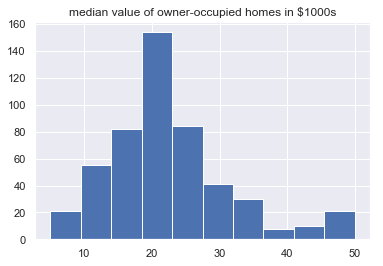

In [14]:
plt.hist(df['value'])
plt.title('median value of owner-occupied homes in $1000s');

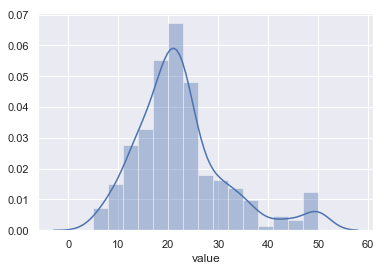

In [15]:
sns.distplot(df['value'], bins=15);

Also, let's look at the distribution of our categorical values `highway`.

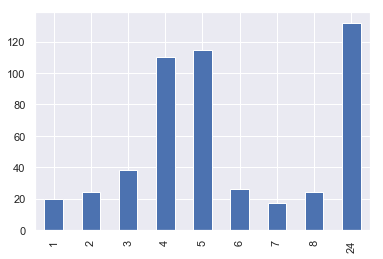

In [16]:
df['highway'].value_counts().sort_index().plot.bar();

Furthermore, a distribution plot for all of our features:

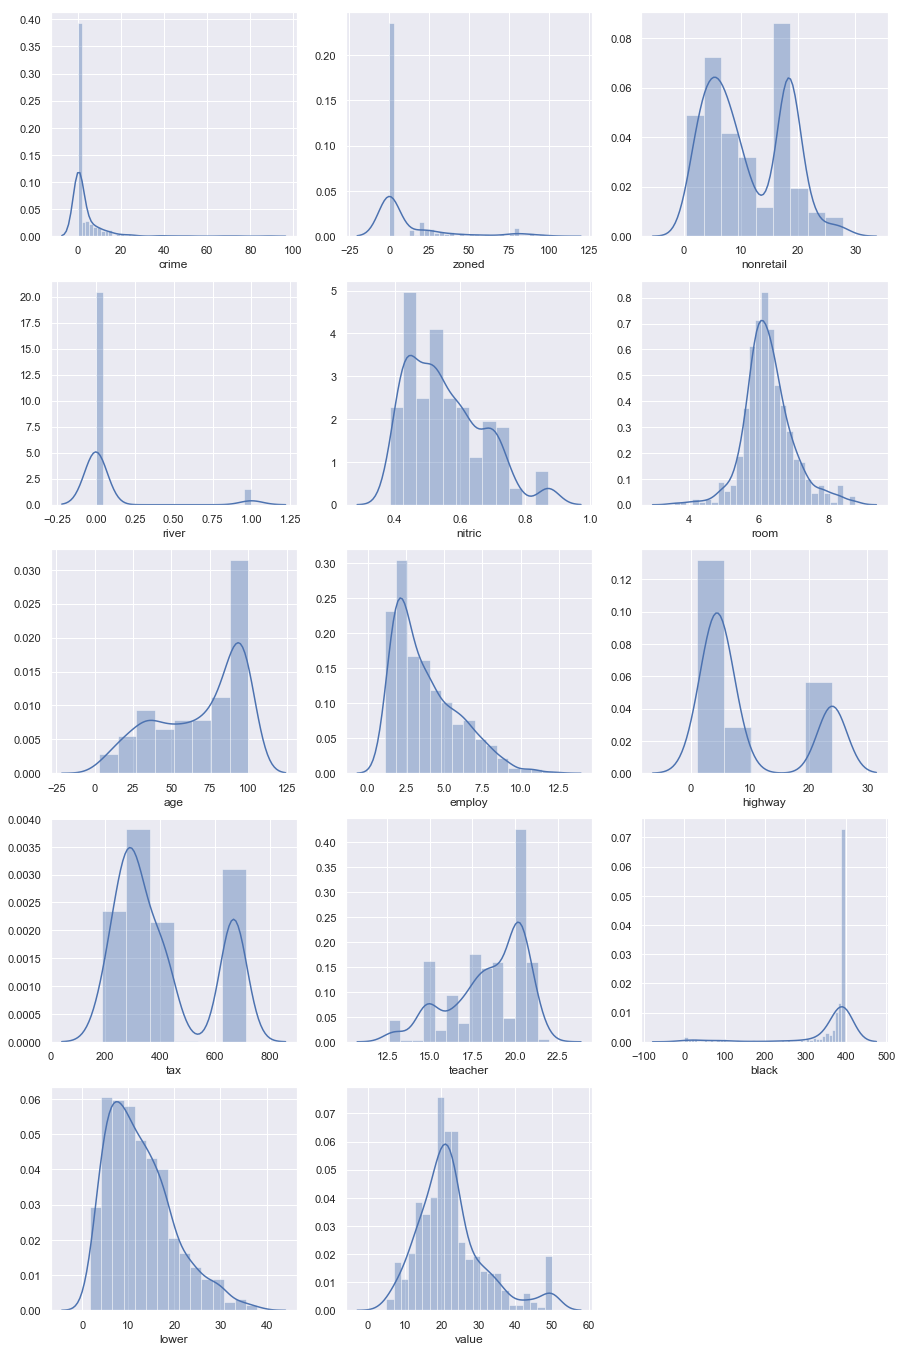

In [17]:
l = df.columns.values
number_of_columns=3
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(5*number_of_columns,5*number_of_rows)) # the number 5 here is arbitrary

for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]])

We mentioned that `river` is mostly zero. But before we decide dropping this feature, we should look at the distribution of `value` when the data is separated by `river`. Here is the comparsion:

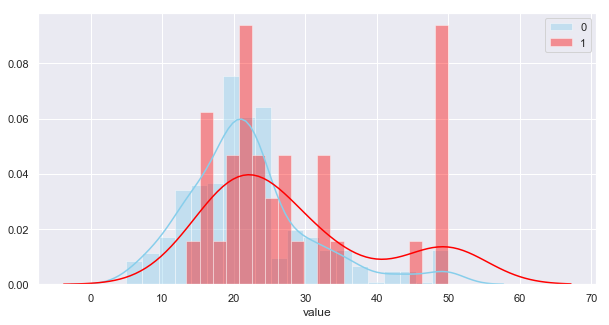

In [18]:
plt.figure(figsize=(10, 5))
sns.distplot(df[df.river==0].value, color="skyblue", label="0", bins=20)
sns.distplot(df[df.river==1].value, color="red", label="1", bins=20)
plt.legend();

The two distribution are very similar. It suggests `river` has very little predictive effect and might be dropped.

Next, we can also look at the pairplot, without the categorical variables:

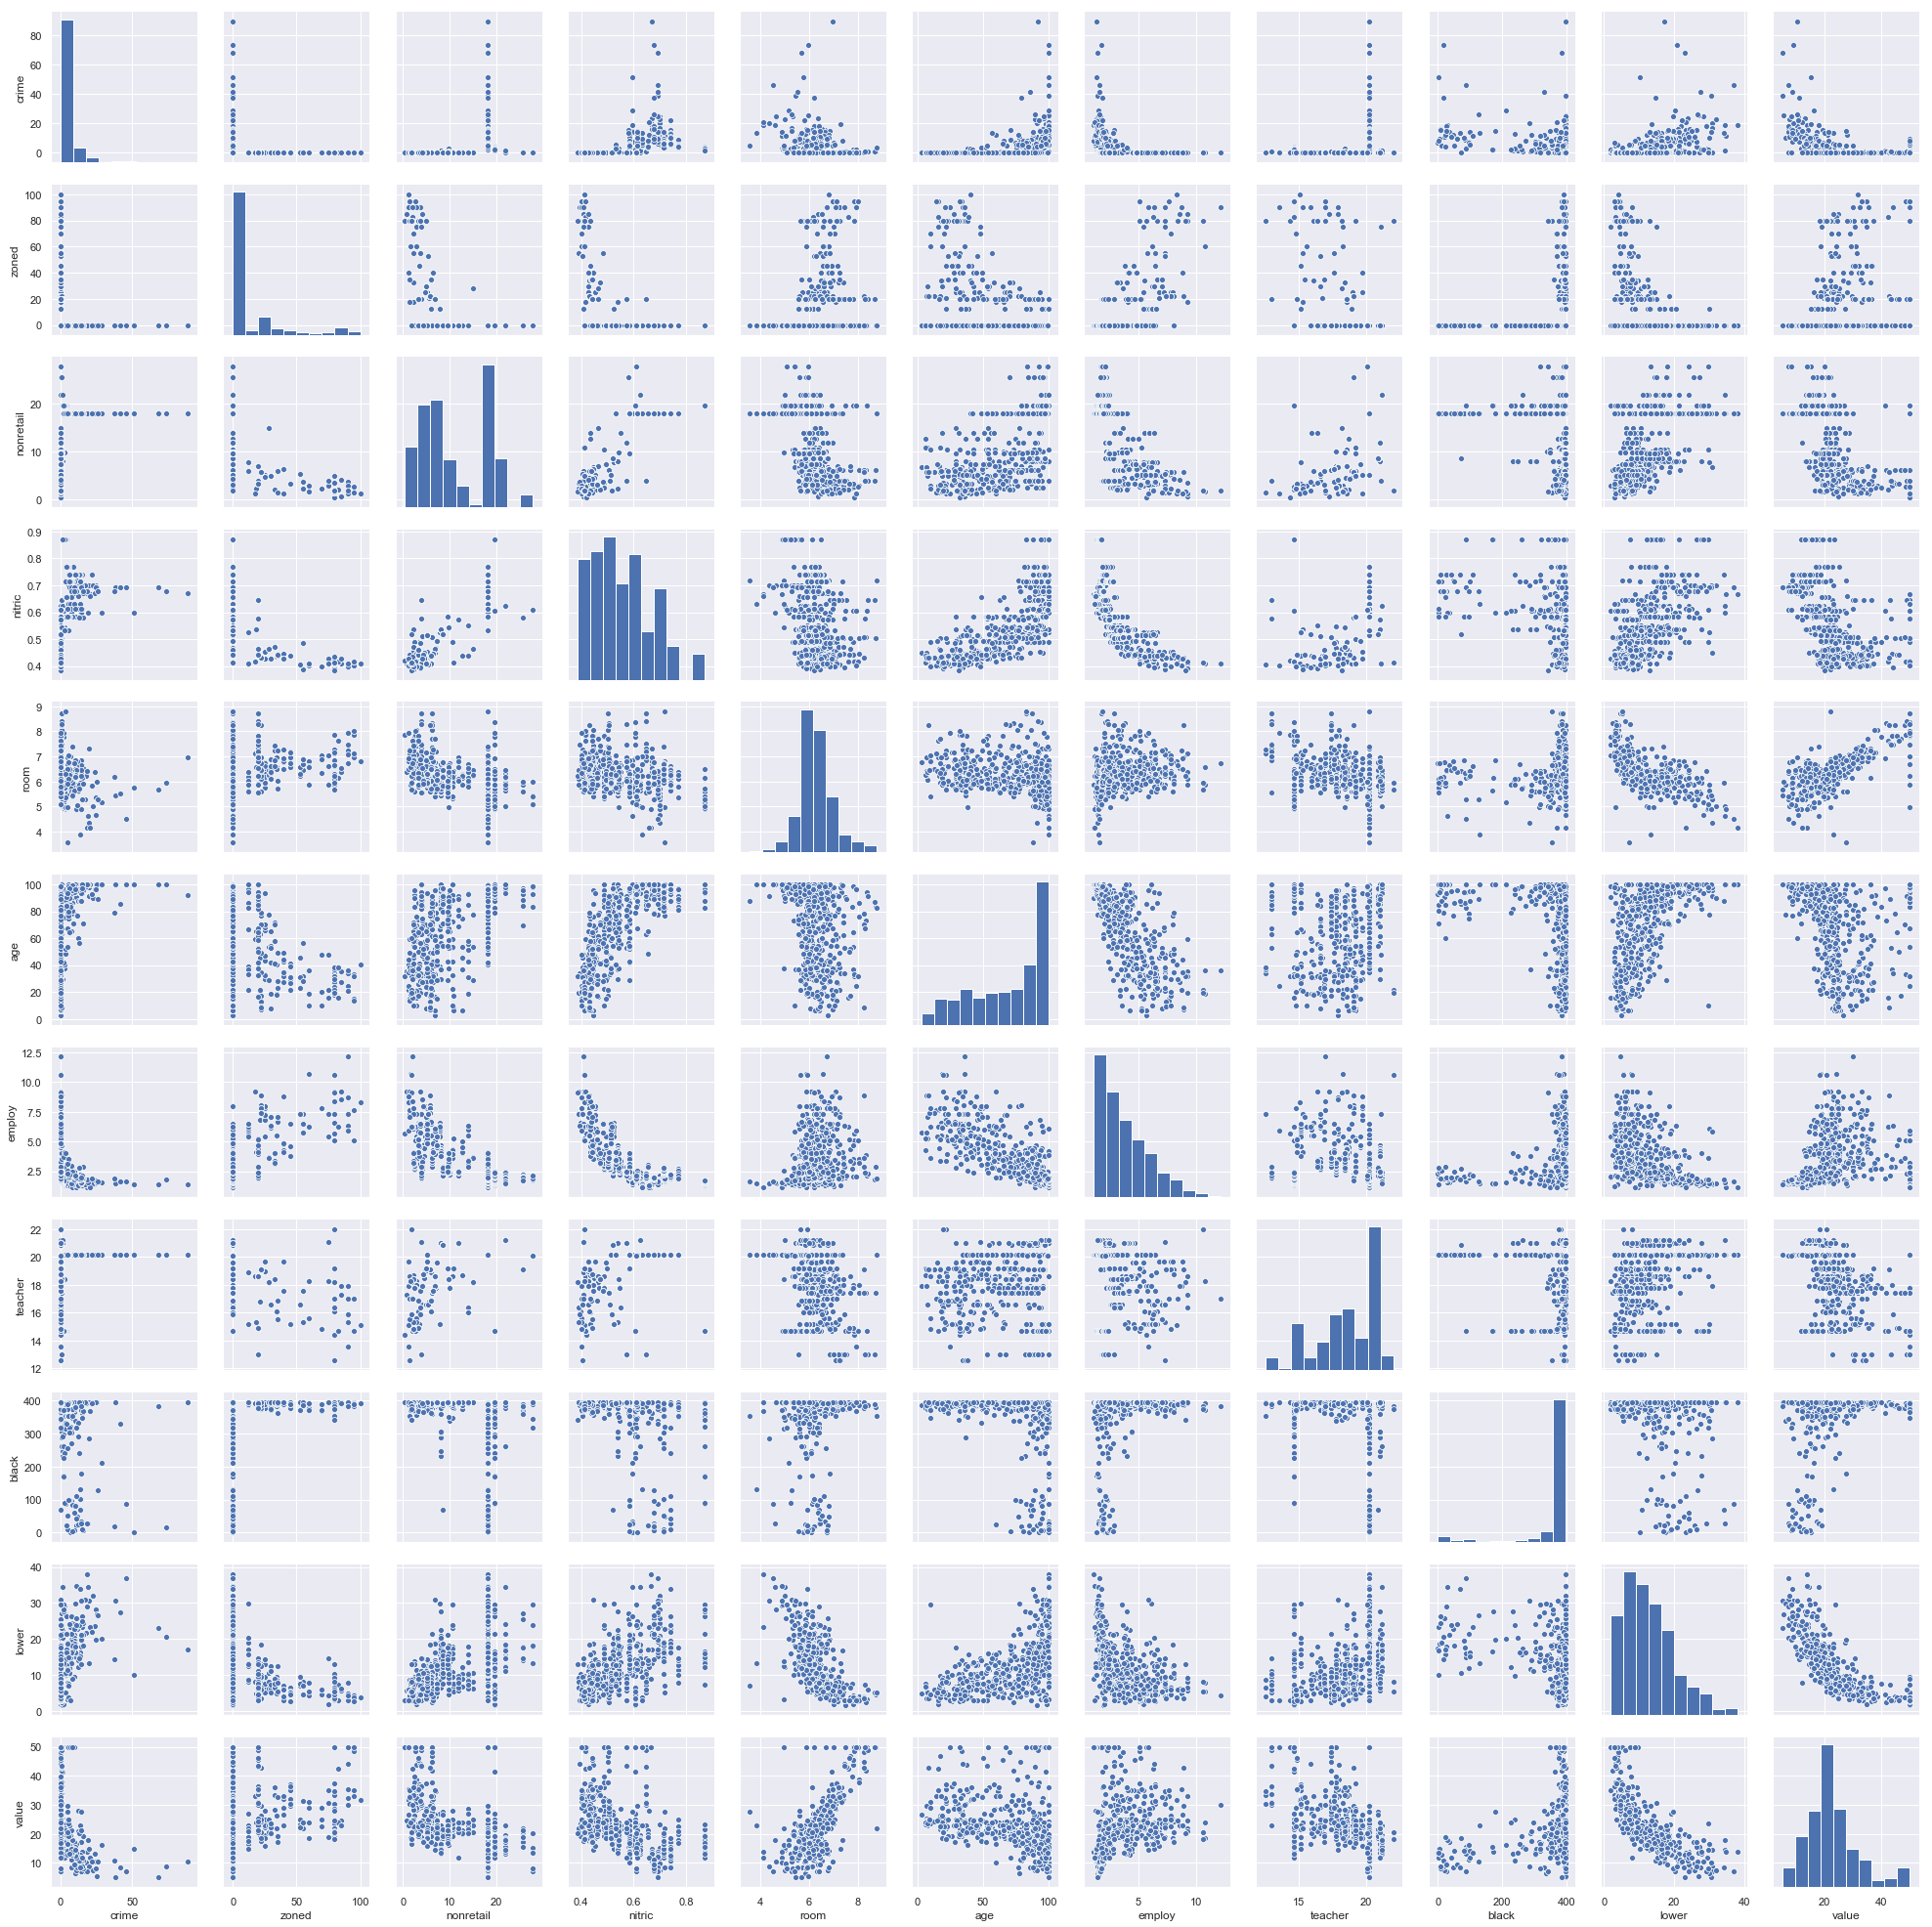

In [19]:
df_numerical = df.drop(columns=['river', 'highway', 'tax'])
sns.pairplot(df_numerical);

Finally, let's check if any of the features are correlated. We can do it by computing the heatmap:

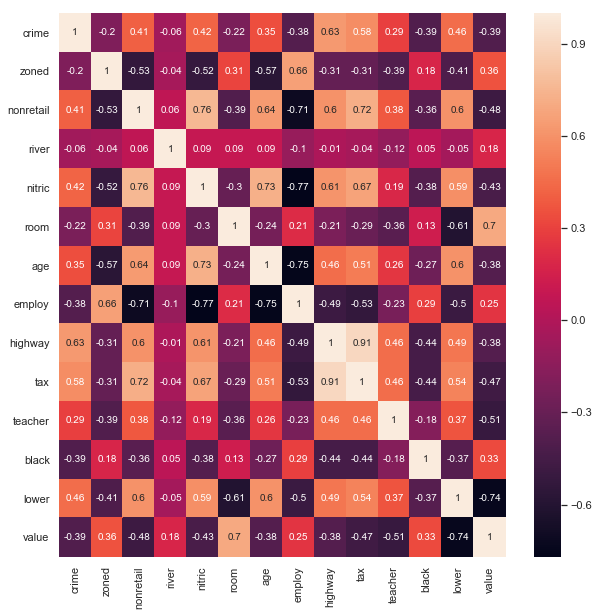

In [20]:
df[['river', 'highway', 'tax']] = df[['river', 'highway', 'tax']].astype('float64')
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(10, 10))
sns.heatmap(data=correlation_matrix, annot=True);

Many pairs of features have a significant correlation. We can't afford to remove to many of them. But `tax` and `highway` have a correlation of 0.91 - maybe it is helpful if we drop one of them (let say `highway`).

## Deep Learning

We are going to drop the features `river` and `highway`.

In [21]:
df.drop(columns=['river', 'highway'], inplace=True)

X = df.drop(columns=['value']).values
X = X.astype(np.float32)

y = df['value'].values
y = y[:, np.newaxis]

We will keep 20% of the data as testing set.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

As we mentioned before, scaling is necessary for our data.

In [23]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

And now, we can finally present `torch`!

In [24]:
import torch
import torch.nn as nn

Don't forget to change all our `numpy` arrays to `torch` tensors.

In [25]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

We will employ a very simple feedforward neural network.

In [26]:
class FeedForward(nn.Module):
    
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(11, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
    
    def forward(self, X):
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return X

net = FeedForward()

We can take a look at how the parameters are initialized:

In [27]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.2257, -0.1586, -0.2624, -0.0894,  0.2723, -0.2170,  0.2195, -0.1996,
          -0.1958, -0.2142,  0.2834],
         [-0.0836, -0.0900, -0.2514,  0.0099, -0.2234,  0.0164, -0.2773,  0.1245,
           0.0826,  0.0076,  0.0188],
         [-0.0234,  0.0450, -0.0754, -0.1443,  0.2142, -0.0793, -0.2787, -0.0064,
          -0.0673,  0.0532, -0.2222],
         [-0.1889,  0.1596,  0.2470,  0.1256, -0.2135, -0.1289,  0.0971,  0.0374,
          -0.1415, -0.1130,  0.2542],
         [ 0.0770,  0.0273,  0.1591,  0.0596, -0.2738,  0.2686, -0.0563, -0.1290,
           0.0850, -0.1869,  0.2650],
         [-0.2622,  0.2770, -0.1954,  0.1878, -0.2204, -0.0979,  0.2315, -0.2783,
          -0.1867, -0.0810, -0.1479],
         [ 0.0785, -0.2751,  0.0426,  0.0522, -0.2460,  0.2907, -0.1594,  0.0321,
           0.2073,  0.0173, -0.2279],
         [ 0.0959,  0.2158,  0.1515,  0.2028,  0.1221, -0.1814, -0.2621,  0.2717,
           0.2836, -0.0969, -0.1577]], requires_grad=Tr

Here is an overview of our network:

In [28]:
print(net)

FeedForward(
  (fc1): Linear(in_features=11, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


`torchsummary` could provide a more detailed overview, including the number of parameters:

In [29]:
from torchsummary import summary

summary(net, input_size=(11, )) # 8 * (11 + 1) = 96, 4 * (8 + 1) = 36, 1 * (4 + 1) = 5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              96
            Linear-2                    [-1, 4]              36
            Linear-3                    [-1, 1]               5
Total params: 137
Trainable params: 137
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


We will use Adam as our optimizer. And of course, the loss function would be an MSE loss.

In [30]:
from torch import optim

optimizer = optim.Adam(net.parameters(), lr=0.1) # Other options: Adagrad, Adam, RMSprop, 
criterion = nn.MSELoss() # Other options: L1Loss, CrossEntropyLoss, SmoothL1Loss

Training begins:

In [31]:
for epoch in range(500):
    
    optimizer.zero_grad()
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    
    if epoch % 30 == 0:
        print(loss)
        
    loss.backward()
    optimizer.step()

print('Finished Training')

tensor(600.5823, grad_fn=<MseLossBackward>)
tensor(153.1213, grad_fn=<MseLossBackward>)
tensor(84.1481, grad_fn=<MseLossBackward>)
tensor(51.6717, grad_fn=<MseLossBackward>)
tensor(39.2787, grad_fn=<MseLossBackward>)
tensor(30.0569, grad_fn=<MseLossBackward>)
tensor(20.2734, grad_fn=<MseLossBackward>)
tensor(14.8360, grad_fn=<MseLossBackward>)
tensor(11.8677, grad_fn=<MseLossBackward>)
tensor(9.9756, grad_fn=<MseLossBackward>)
tensor(8.5213, grad_fn=<MseLossBackward>)
tensor(7.5362, grad_fn=<MseLossBackward>)
tensor(6.7751, grad_fn=<MseLossBackward>)
tensor(5.9200, grad_fn=<MseLossBackward>)
tensor(5.3228, grad_fn=<MseLossBackward>)
tensor(4.9440, grad_fn=<MseLossBackward>)
tensor(4.6384, grad_fn=<MseLossBackward>)
Finished Training


It is working pretty well on our training data. Let's see how does it perform on testing data.

In [32]:
y_pred = net(X_test)
criterion(y_pred, y_test)

tensor(37.6043, grad_fn=<MseLossBackward>)

We got a large number because the error is squared in L2 loss. It is better to consider L1 loss:

In [33]:
criterion2 = nn.L1Loss()
criterion2(y_pred, y_test)

tensor(3.7065, grad_fn=<L1LossBackward>)

That is great! Our average error is just $3,700, and I will take that as a win for such a simple model.

We can plot our result on a graph:

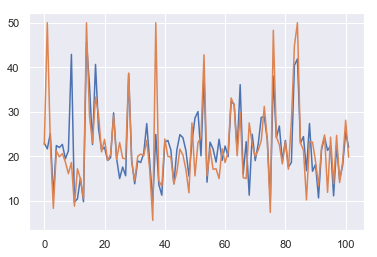

In [34]:
y_pred = y_pred.data.numpy()

plt.plot(y_pred)
plt.plot(y_test);

Our model did a good job most of the time. However, it might give a huge difference sometimes.